# H20 Scaling for Telluric Correction

Notebook for developing ideas to go into TellRemoval code.

Need to apply scaling of T^x to transmision of water at full resolving power and then apply a kernal to apply in at resolution of CRIRES.

Fit to the observed data (Probably with the other lines removed) to fnd the best x to apply for the correction. (Gives flatest result or zero linewidth.) 


In [3]:
### Load modules and Bokeh
# Imports from __future__ in case we're running Python 2
from __future__ import division, print_function
from __future__ import absolute_import, unicode_literals

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Seaborn, useful for graphics
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.mpl
import bokeh.plotting

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
#%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 1, 
      'axes.labelsize': 14, 
      'axes.titlesize': 16, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

Loading BokehJS ...

In [4]:
# Define Faster functions to try
def fast_wav_selector(wav, flux, wav_min, wav_max, verbose=False):
    """ Faster Wavelenght selector
    
    If passed lists it will return lists.
    If passed np arrays it will return arrays
    
    Fastest is using np.ndarrays
    fast_wav_selector ~1000-2000 * quicker than wav_selector
    """
    if isinstance(wav, list): # if passed lists
          wav_sel = [wav_val for wav_val in wav if (wav_min < wav_val < wav_max)]
          flux_sel = [flux_val for wav_val, flux_val in zip(wav,flux) if (wav_min < wav_val < wav_max)]
    elif isinstance(wav, np.ndarray):
        # Super Fast masking with numpy
        mask = (wav > wav_min) & (wav < wav_max)
        if verbose:
            print("mask=", mask)
            print("len(mask)", len(mask))
            print("wav", wav)
            print("flux", flux)
        wav_sel = wav[mask]
        flux_sel = flux[mask]
    else:
          raise TypeError("Unsupported input wav type")
    return [wav_sel, flux_sel]

### Load in Observed Data

In [5]:
# Need to update these to the vacuum with no berv corrections
chip1 = "CRIRE.2012-04-07T00-08-29.976_1.nod.ms.norm.sum.wavecal.fits"
chip2 = "CRIRE.2012-04-07T00-08-29.976_2.nod.ms.norm.sum.wavecal.fits"
chip3 = "CRIRE.2012-04-07T00-08-29.976_3.nod.ms.norm.sum.wavecal.fits"
chip4 = "CRIRE.2012-04-07T00-08-29.976_4.nod.ms.norm.sum.wavecal.fits" 

Obs1 = fits.getdata(chip1) 
hdr1 = fits.getheader(chip1) 
Obs2 = fits.getdata(chip2) 
hdr2 = fits.getheader(chip2) 
Obs3 = fits.getdata(chip3) 
hdr3 = fits.getheader(chip3) 
Obs4 = fits.getdata(chip4) 
hdr4 = fits.getheader(chip4) 

print("Column names = {}".format(Obs1.columns.names))
wl1 = Obs1["Wavelength"]
I1_uncorr = Obs1["Extracted_DRACS"]

wl2 = Obs2["Wavelength"]
I2_uncorr = Obs2["Extracted_DRACS"]

wl3 = Obs3["Wavelength"]
I3_uncorr = Obs3["Extracted_DRACS"]

wl4 = Obs4["Wavelength"]
I4_uncorr = Obs4["Extracted_DRACS"]

start_airmass = hdr1["HIERARCH ESO TEL AIRM START"]
end_airmass = hdr1["HIERARCH ESO TEL AIRM END"]
obs_airmass = (start_airmass + end_airmass) / 2
print("Data from Detectors is now loaded")


Column names = ['Wavelength', 'Extracted_DRACS', 'Pixel']
Data from Detectors is now loaded


In [6]:
## Rough berv correction until input calibrated file is calibrated with non berv tapas 

In [7]:
wl1 = wl1-.5   #including rough berv correction
wl2 = wl2-.54  #including rough berv correction
wl3 = wl3-.55  #including rough berv correction
wl4 = wl4-.7

### Load in the tapas data

In [8]:
import Obtain_Telluric as obt
tapas_all = "tapas_2012-04-07T00-24-03_ReqId_10_R-50000_sratio-10_barydone-NO.ipac"
tapas_h20 = "tapas_2012-04-07T00-24-03_ReqId_12_No_Ifunction_barydone-NO.ipac"
tapas_not_h20 = "tapas_2012-04-07T00-24-03_ReqId_18_R-50000_sratio-10_barydone-NO.ipac"

tapas_all_data, tapas_all_hdr = obt.load_telluric("", tapas_all)
tapas_all_airmass = float(tapas_all_hdr["airmass"])

print("Telluric Airmass ", tapas_all_airmass)
tapas_all_respower = int(float((tapas_all_hdr["respower"])))
print("Telluric Resolution Power =", tapas_all_respower)

tapas_h20_data, tapas_h20_hdr = obt.load_telluric("", tapas_h20)
tapas_h20_airmass = float(tapas_h20_hdr["airmass"])

print("Telluric Airmass ", tapas_h20_airmass)
try:
    tapas_h20_respower = int(float((tapas_h20_hdr["respower"])))
except:
    tapas_h20_respower = "Nan"
print("Telluric Resolution Power =", tapas_h20_respower)

tapas_not_h20_data, tapas_not_h20_hdr = obt.load_telluric("", tapas_not_h20)
tapas_not_h20_airmass = float(tapas_not_h20_hdr["airmass"])

print("Telluric Airmass ", tapas_not_h20_airmass)
tapas_not_h20_respower = int(float((tapas_not_h20_hdr["respower"])))
print("Telluric Resolution Power =", tapas_not_h20_respower)
    
#print(tapas_all_hdr)


Telluric Airmass  1.628051
Telluric Resolution Power = 50000
Telluric Airmass  1.628051
Telluric Resolution Power = Nan
Telluric Airmass  1.628051
Telluric Resolution Power = 50000


In [8]:
type(tapas_h20_data)

numpy.ndarray

### Plot the data
Including the 3 tapas models to show they align well and are consistent.


In [ ]:
plt.plot(wl1, I1_uncorr, 'b') #including rough berv correction
plt.plot(wl2, I2_uncorr, 'b') #including rough berv correction
plt.plot(wl3, I3_uncorr, 'b') #including rough berv correction
plt.plot(wl4, I4_uncorr, 'b') #including rough berv correction
plt.plot(tapas_h20_data[0], tapas_h20_data[1], "--k", label="H20")
plt.plot(tapas_all_data[0], tapas_all_data[1], "-r", label="all")
plt.plot(tapas_not_h20_data[0], tapas_not_h20_data[1], "-.g", label="Not H20")

#plt.legend()

# Make it interactive with Bokeh
bokeh.plotting.show(bokeh.mpl.to_bokeh())

### Remove non-H20 lines
(Use telluric removal modules)
And plot the result.  

In [9]:
from TellRemoval import divide_spectra, airmass_scaling, telluric_correct, match_wl

def correction(wl_obs, spec_obs, wl_tell, spec_tell, obs_airmass, tell_airmass, kind="linear", method="scipy"):
    interped_tell = match_wl(wl_tell, spec_tell, wl_obs)
    scaled_tell = airmass_scaling(interped_tell, tell_airmass, obs_airmass)
    corr_spec = divide_spectra(spec_obs, scaled_tell)                        # Divide by scaled telluric spectra
    return corr_spec
    
def faster_correction(wl_obs, spec_obs, wl_tell, spec_tell, obs_airmass, tell_airmass, kind="linear", method="scipy"):
    interped_tell = match_wl(wl_tell, spec_tell, wl_obs)
    scaled_tell = airmass_scaling(interped_tell, tell_airmass, obs_airmass)
    corr_spec = divide_spectra(spec_obs, scaled_tell)                        # Divide by scaled telluric spectra
    return corr_spec
#def telluric_correct(wl_obs, spec_obs, wl_tell, spec_tell, obs_airmass, tell_airmass, kind="linear", method="scipy"):
#    return Corrections, Correction_tells, Correction_Bs, Correction_labels

# Corrections, Correction_tells, Correction_Bs, Correction_labels = telluric_correct(wl2, I2_uncorr, tapas_not_h20[0], tapas_not_h20[1], obs_airmass, tapas_not_h20_airmass) 
# Getting zero division error from this function so will try it again from te functions here
tell_airmass = tapas_not_h20_airmass

I1_not_h20_corr = correction(wl1, I1_uncorr, tapas_not_h20_data[0], tapas_not_h20_data[1], obs_airmass, tapas_not_h20_airmass, kind="linear", method="scipy")
I2_not_h20_corr = correction(wl2, I2_uncorr, tapas_not_h20_data[0], tapas_not_h20_data[1], obs_airmass, tapas_not_h20_airmass, kind="linear", method="scipy")
I3_not_h20_corr = correction(wl3, I3_uncorr, tapas_not_h20_data[0], tapas_not_h20_data[1], obs_airmass, tapas_not_h20_airmass, kind="linear", method="scipy")
I4_not_h20_corr = correction(wl4, I4_uncorr, tapas_not_h20_data[0], tapas_not_h20_data[1], obs_airmass, tapas_not_h20_airmass, kind="linear", method="scipy")
        


linear scipy interpolation
Interpolation Time = 0.003000020980834961 seconds
linear scipy interpolation
Interpolation Time = 0.002000093460083008 seconds
linear scipy interpolation
Interpolation Time = 0.002000093460083008 seconds
linear scipy interpolation
Interpolation Time = 0.002001047134399414 seconds


In [ ]:
# Need to remove print statement from iterpolation timing to run this again.
#%timeit correction(wl1, I1_uncorr, tapas_not_h20_data[0], tapas_not_h20_data[1], obs_airmass, tapas_not_h20_airmass, kind="linear", method="scipy")


# not yet any changes to mkae faster.
#%timeit faster_correction(wl1, I1_uncorr, tapas_not_h20_data[0], tapas_not_h20_data[1], obs_airmass, tapas_not_h20_airmass, kind="linear", method="scipy")


In [ ]:
# Plot not h20 correction

plt.plot(wl1, I1_uncorr, "b")
plt.plot(wl2, I2_uncorr, "b")
plt.plot(wl3, I3_uncorr, "b")
plt.plot(wl4, I4_uncorr, "b")
plt.plot(wl1, I1_not_h20_corr, "r")
plt.plot(wl2, I2_not_h20_corr, "r")
plt.plot(wl3, I3_not_h20_corr, "r")
plt.plot(wl4, I4_not_h20_corr, "r")
plt.plot(tapas_not_h20_data[0], tapas_not_h20_data[1], "k")
# Make it interactive with Bokeh
bokeh.plotting.show(bokeh.mpl.to_bokeh())

# Convolution from Pyastronomy
This function broadens a spectrum assuming a Gaussian kernel. The width of the kernel is determined by the resolution. In particular, the function will determine the mean wavelength and set the Full Width at Half Maximum (FWHM) of the Gaussian to (mean wavelength)/resolution.
Parameters :    
wvl : array
    The wavelength

flux : array
    The spectrum

resolution : int
    The spectral resolution.
    

The Pyastronomy convolution needs equidistant points to work. This involves performing an interpolation. We prefer not to use this method as it losses information.

In [ ]:
# Just to my CRIRES range 
from PyAstronomy import pyasl    
R = 50000  

chipmin = float(hdr1["HIERARCH ESO INS WLEN STRT1"])  # Wavelength start on detector [nm]
chipmax = float(hdr1["HIERARCH ESO INS WLEN END4"])   # Wavelength end on detector [nm]
wav_chip, flux_chip = fast_wav_selector(tapas_h20_data[0], tapas_h20_data[1], chipmin, chipmax)

FWHM_min = wav_chip[0]/R    #FWHM at the extremes of vector
FWHM_max = wav_chip[-1]/R   

print("Min FWHM", FWHM_min)
print("Max FWHM", FWHM_max)

# pyasl needs equidistant wavelenghts 

from Find_gcdt import gcdt
greatest_common_divisor = gcdt(wav_chip, 4)
print("Found divisor = ", greatest_common_divisor)
steps = (wav_chip[-1] - wav_chip[0])/greatest_common_divisor
print("NUmber of steps =", steps)

new_wav = np.linspace(wav_chip[0], wav_chip[-1], num=steps, endpoint=True)

# Inperolate_to_new_wave  
new_flux = match_wl(wav_chip, flux_chip, new_wav)
print("length of new flux", len(new_flux))

diffs = np.diff(wav_chip)
print("First Diff={}, last diff={}".format(diffs[0], diffs[-1]))

data_step = 2 * (wav_chip[-1] - wav_chip[0])/np.min(diffs) 
new_diff_wav = np.linspace(wav_chip[0], wav_chip[-1], num=data_step, endpoint=True)

new_diff_flux = match_wl(wav_chip, flux_chip, new_diff_wav)
print("length of new flux", len(new_diff_flux))

#new_flux = np.interp(new_wav, wav_chip, flux_chip)

# Prefer not to use this method
Conv_flux_pysal = pyasl.instrBroadGaussFast(new_wav, new_flux, 50000, edgeHandling=None, fullout=False, maxsig=None)

print("done")

In [ ]:
# PLot Pyasl convolution
plt.plot(tapas_h20_data[0], tapas_h20_data[1],"b")
plt.plot(new_wav,Conv_flux_pysal, "r")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Flux")
plt.title("Test of Pyasl convolution \n (Used interpolation to equidistant points)")
#plt.show()
# Make it interactive with Bokeh
bokeh.plotting.show(bokeh.mpl.to_bokeh())

# No interpolation convolution 
Speed up with numpy mask instead of comprehnsion list

In [ ]:
# Chip version
def chip_selector(wav, flux, chip):
    # This uses hdr that does not live in this function !!!!!
    chip = str(chip)
    if(chip in ["ALL", "all", "","0"]):
        chipmin = float(hdr1["HIERARCH ESO INS WLEN STRT1"])  # Wavelength start on detector [nm]
        chipmax = float(hdr1["HIERARCH ESO INS WLEN END4"])   # Wavelength end on detector [nm]
        #return [wav, flux]
    elif(chip == "1"):
        chipmin = float(hdr1["HIERARCH ESO INS WLEN STRT1"])  # Wavelength start on detector [nm]
        chipmax = float(hdr1["HIERARCH ESO INS WLEN END1"])   # Wavelength end on detector [nm]
    elif(chip == "2"):
        chipmin = float(hdr1["HIERARCH ESO INS WLEN STRT2"])  # Wavelength start on detector [nm]
        chipmax = float(hdr1["HIERARCH ESO INS WLEN END2"])   # Wavelength end on detector [nm]
    elif(chip == "3"):   
        chipmin = float(hdr1["HIERARCH ESO INS WLEN STRT3"])  # Wavelength start on detector [nm]
        chipmax = float(hdr1["HIERARCH ESO INS WLEN END3"])   # Wavelength end on detector [nm]
    elif(chip == "4"):   
        chipmin = float(hdr1["HIERARCH ESO INS WLEN STRT4"])  # Wavelength start on detector [nm]
        chipmax = float(hdr1["HIERARCH ESO INS WLEN END4"])   # Wavelength end on detector [nm]
    elif(chip == "Joblib_small"):   
        chipmin = float(2118)  # Wavelength start on detector [nm]
        chipmax = float(2119)  # Wavelength end on detector [nm]
    elif(chip == "Joblib_large"):   
        chipmin = float(2149)  # Wavelength start on detector [nm]
        chipmax = float(2157)  # Wavelength end on detector [nm]
    else:
        print("Unrecognized chip tag.")
        exit()
    
    #select values form the chip  
    wav_chip, flux_chip = fast_wav_selector(wav, flux, chipmin, chipmax)
    
    return [wav_chip, flux_chip]


def convolution_nir_chip(wav, flux, chip, R, FWHM_lim=5.0, plot=True, verbose=True):
    """Convolution code adapted from pedros code and speed up with np mask logic"""
    """ this version keeps the chip values from chip selector"""
    #print("types", type(wav), type(flux), type(chip))
    #print("lengths", len(wav), len(flux), len(chip))
    
    # CRIRES HDR vals for chip limits don't match well with calibrated values (get interpolation out of range error)
    # So will use limits from the obs data instead 
    wav_chip, flux_chip = chip_selector(wav, flux, chip)
    #wav_chip, flux_chip = fast_wav_selector(wav, flux, chip_limits[0], chip_limits[1])
    #we need to calculate the FWHM at this value in order to set the starting point for the convolution
    
    FWHM_min = wav_chip[0]/R    #FWHM at the extremes of vector
    FWHM_max = wav_chip[-1]/R       
    
    #wide wavelength bin for the resolution_convolution
    wav_extended, flux_extended = fast_wav_selector(wav, flux, wav_chip[0]-FWHM_lim*FWHM_min, wav_chip[-1]+FWHM_lim*FWHM_max, verbose=False) 
    # isinstance check is ~100*faster then arraying the array again.
    if not isinstance(wav_extended, np.ndarray):
        wav_extended = np.array(wav_extended, dtype="float64") 
    if not isinstance(flux_extended, np.ndarray):
        flux_extended = np.array(flux_extended, dtype="float64")
    
    print("Starting the Resolution convolution...")
    # Predefine np array space
    flux_conv_res = np.empty_like(wav_chip, dtype="float64")
    counter = 0 
    base_val = len(wav_chip)//20   # Adjust here to change % between reports
    
    for n, wav in enumerate(wav_chip):
        # put value directly into the array
        flux_conv_res[n] = fast_convolve(wav, R, wav_extended, flux_extended, FWHM_lim)
        if(n%base_val== 0) and verbose:
            counter = counter+5
            print("Resolution Convolution at {}%%...".format(counter))
    
    #if not isinstance(flux_conv_res, np.ndarray):
    #    flux_conv_res = np.array(flux_conv_res, dtype="float64")
        
    print("Done.\n")
    
    if(plot):
        fig=plt.figure(1)
        plt.xlabel(r"wavelength [ $\mu$m ])")
        plt.ylabel(r"flux [counts] ")
        plt.plot(wav_chip, flux_chip/np.max(flux_chip), color ='k', linestyle="-", label="Original spectra")
        plt.plot(wav_chip, flux_conv_res/np.max(flux_conv_res), color ='b', linestyle="-", label="Spectrum observed at and R=%d ." % (R))
        plt.legend(loc='best')
        plt.show() 
    return [wav_chip, flux_conv_res]

### Convole instrument profile function:
To use inside fit

In [10]:
## USEFUL functions from pedros code:
# This is pedros slow selector
#def wav_selector(wav, flux, wav_min, wav_max):
#    """
#    function that returns wavelength and flux withn a giving range
#    """    
#    wav_sel = np.array([value for value in wav if(wav_min < value < wav_max)], dtype="float64")
#    flux_sel = np.array([value[1] for value in zip(wav,flux) if(wav_min < value[0] < wav_max)], dtype="float64")
#    
#    return [wav_sel, flux_sel]


def unitary_Gauss(x, center, FWHM):
    """
    Gaussian_function of area=1
	
	p[0] = A;
	p[1] = mean;
	p[2] = FWHM;
    """
    
    sigma = np.abs(FWHM) /( 2 * np.sqrt(2 * np.log(2)) );
    Amp = 1.0 / (sigma*np.sqrt(2*np.pi))
    tau = -((x - center)**2) / (2*(sigma**2))
    result = Amp * np.exp( tau );
    
    return result




In [11]:
def fast_convolve(wav_val, R, wav_extended, flux_extended, FWHM_lim):
    """IP convolution multiplication step for a single wavelength value"""
    FWHM = wav_val/R
    
    index_mask = (wav_extended > (wav_val - FWHM_lim*FWHM)) &  (wav_extended < (wav_val + FWHM_lim*FWHM))
    
    flux_2convolve = flux_extended[index_mask]
    IP = unitary_Gauss(wav_extended[index_mask], wav_val, FWHM)
    
    sum_val = np.sum(IP*flux_2convolve) 
    unitary_val = np.sum(IP*np.ones_like(flux_2convolve))  # Effect of convolution onUnitary. For changing number of points
        
    return sum_val/unitary_val

def convolution_nir(wav, flux, chip_limits, R, FWHM_lim=5.0, plot=True, verbose=True):
    """Convolution code adapted from pedros code and speed up with np mask logic"""
    
    #print("types", type(wav), type(flux), type(chip))
    #print("lengths", len(wav), len(flux), len(chip))
    
    # CRIRES HDR vals for chip limits don't match well with calibrated values (get interpolation out of range error)
    # So will use limits from the obs data instead 
    #wav_chip, flux_chip = chip_selector(wav, flux, chip)
    wav_chip, flux_chip = fast_wav_selector(wav, flux, chip_limits[0], chip_limits[1])
    #we need to calculate the FWHM at this value in order to set the starting point for the convolution
    
    FWHM_min = wav_chip[0]/R    #FWHM at the extremes of vector
    FWHM_max = wav_chip[-1]/R       
    
    #wide wavelength bin for the resolution_convolution
    wav_extended, flux_extended = fast_wav_selector(wav, flux, wav_chip[0]-FWHM_lim*FWHM_min, wav_chip[-1]+FWHM_lim*FWHM_max, verbose=False) 
    # isinstance check is ~100*faster then arraying the array again.
    if not isinstance(wav_extended, np.ndarray):
        wav_extended = np.array(wav_extended, dtype="float64") 
    if not isinstance(flux_extended, np.ndarray):
        flux_extended = np.array(flux_extended, dtype="float64")
    
    print("Starting the Resolution convolution...")
    # Predefine np array space
    flux_conv_res = np.empty_like(wav_chip, dtype="float64")
    counter = 0 
    base_val = len(wav_chip)//20   # Adjust here to change % between reports
    
    for n, wav in enumerate(wav_chip):
        # put value directly into the array
        flux_conv_res[n] = fast_convolve(wav, R, wav_extended, flux_extended, FWHM_lim)
        if(n%base_val== 0) and verbose:
            counter = counter+5
            print("Resolution Convolution at {}%%...".format(counter))
    
    #if not isinstance(flux_conv_res, np.ndarray):
    #    flux_conv_res = np.array(flux_conv_res, dtype="float64")
        
    print("Done.\n")
    
    if(plot):
        fig=plt.figure(1)
        plt.xlabel(r"wavelength [ $\mu$m ])")
        plt.ylabel(r"flux [counts] ")
        plt.plot(wav_chip, flux_chip/np.max(flux_chip), color ='k', linestyle="-", label="Original spectra")
        plt.plot(wav_chip, flux_conv_res/np.max(flux_conv_res), color ='b', linestyle="-", label="Spectrum observed at and R=%d ." % (R))
        plt.legend(loc='best')
        plt.show() 
    return [wav_chip, flux_conv_res]

print("Done")

Done


## Test convolution runtime

In [14]:
# 10 seconds per loop for chip "1" and plotting   (down from 900s)
#timeit x, y = convolution_nir(tapas_h20_data[0], tapas_h20_data[1], "1", 50000, FWHM_lim=5.0, plot=True)
limits = [2124,2136]
x, y = convolution_nir(tapas_h20_data[0], tapas_h20_data[1], limits, 50000, FWHM_lim=5.0, plot=False)


Starting the Resolution convolution...
Resolution Convolution at 5%%...
Resolution Convolution at 10%%...
Resolution Convolution at 15%%...
Resolution Convolution at 20%%...
Resolution Convolution at 25%%...
Resolution Convolution at 30%%...
Resolution Convolution at 35%%...
Resolution Convolution at 40%%...
Resolution Convolution at 45%%...
Resolution Convolution at 50%%...
Resolution Convolution at 55%%...
Resolution Convolution at 60%%...
Resolution Convolution at 65%%...
Resolution Convolution at 70%%...
Resolution Convolution at 75%%...
Resolution Convolution at 80%%...
Resolution Convolution at 85%%...
Resolution Convolution at 90%%...
Resolution Convolution at 95%%...
Resolution Convolution at 100%%...
Resolution Convolution at 105%%...
Done.



In [ ]:
# Profile to see what takes the most time
%prun x, y = convolution_nir(tapas_h20_data[0], tapas_h20_data[1], limits, 50000, FWHM_lim=5.0, plot=False)
# Answer is the IP calculation

Time on work comp - 188.6781919 s  

In [ ]:
plt.plot(tapas_h20_data[0], tapas_h20_data[1],"b")
plt.plot(x, y, "r")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Flux")
plt.title("Test of convolution")
#plt.show()
# Make it interactive with Bokeh
bokeh.plotting.show(bokeh.mpl.to_bokeh())

# Fit H20 Scaling Power
Does each chip need a differnet scaling power?


In [16]:
from lmfit import minimize, Parameters
import lmfit

In [17]:
from scipy.interpolate import interp1d
#from TellRemoval import divide_spectra, airmass_scaling, telluric_correct, match_wl
def match_wl(wl, spec, ref_wl, method="scipy", kind="linear"):
    """Interpolate Wavelengths of spectra to common WL
    Most likely convert telluric to observed spectra wl after wl mapping performed"""
    #starttime = time.time()
    if method == "scipy":
        #print(kind + " scipy interpolation")
        linear_interp = interp1d(wl, spec, kind=kind)
        new_spec = linear_interp(ref_wl)
    elif method == "numpy":
        if kind.lower() is not "linear":
            print("Warning: Cannot do " + kind + " interpolation with numpy, switching to linear" )
        #print("Linear numpy interpolation")
        new_spec = np.interp(ref_wl, wl, spec)  # 1-d peicewise linear interpolat
    else:
        print("Method was given as " + method)
        raise("Not correct interpolation method specified")
    #print("Interpolation Time = " + str(time.time() - starttime) + " seconds")

    return new_spec  # test inperpolations 



In [18]:
### Fit using lmfit

def h20_residual(params, obs_data, telluric_data):
    # Parameters 
    ScaleFactor = params["ScaleFactor"].value
    R = params["R"].value
    FWHM_lim = params["FWHM_lim"].value
    #n_jobs = params["n_jobs"].value  # parallel implementaiton
    #chip_select = params["chip_select"].value
    verbose = params["verbose"].value
    
    # Data
    obs_wl = obs_data[0]
    obs_I = obs_data[1]
    telluric_wl = telluric_data[0]
    telluric_I = telluric_data[1]
    
    # Telluric scaling T ** x
    scaled_telluric_I = telluric_I ** ScaleFactor
    
    # smallest wl step in telluric wl
    min_dwl = np.min(telluric_wl[1:]-telluric_wl[:-1])
    # Make sure atleast 1 telluric value is outside wl range of observation for interpoltion later 
    chip_limits = [obs_wl[0]-2*min_dwl, obs_wl[-1]+2*min_dwl] 
    # Convolution
    #def convolution_nir(wav, flux, chip, R, FWHM_lim=5.0, plot=True):
    #    return [wav_chip, flux_conv_res]
    conv_tell_wl, conv_tell_I = convolution_nir(telluric_wl, scaled_telluric_I, chip_limits,
                                                R, FWHM_lim=FWHM_lim, plot=False, verbose=verbose)
    
    print("Obs wl- Min ", np.min(obs_wl)," Max ", np.max(obs_wl))
    print("Input telluic wl- Min ", np.min(telluric_wl)," Max ", np.max(telluric_wl))
    print("conv tell wl- Min ", np.min(conv_tell_wl)," Max ", np.max(conv_tell_wl))
  
    
    interped_conv_tell = match_wl(conv_tell_wl, conv_tell_I, obs_wl)
    print("Convolution and interpolation inside residual function was done")
    
    return 1 - (obs_I / interped_conv_tell) 




In [23]:
# Set up parameters 
params = Parameters()
params.add('ScaleFactor', value=1)   # add min and max values ?
params.add('R', value=50000, vary=False)
params.add('FWHM_lim', value=5, vary=False)
#params.add('n_jobs', value=-1, vary=False)
#params.add('chip_select', value=2, vary=False)


In [24]:
#wl2, I2_uncorr
# wl2, I2_not_h20_corr

# Sliced to wavelength measurement of detector
#tell_data1 = fast_wav_selector(tapas_h20_data[0], tapas_h20_data[1], np.min(wl1), np.max(wl1))
tell_data2 = fast_wav_selector(tapas_h20_data[0], tapas_h20_data[1], 0.9995*np.min(wl2), 1.0005*np.max(wl2))
#tell_data3 = fast_wav_selector(tapas_h20_data[0], tapas_h20_data[1], np.min(wl3), np.max(wl3))
#tell_data4 = fast_wav_selector(tapas_h20_data[0], tapas_h20_data[1], np.min(wl4), np.max(wl4))


print("Obs wl- Min ", np.min(wl2)," Max ", np.max(wl2))
print("0.9995*Obs wl min", 0.9995*np.min(wl2)," 1.005*Obs wl max", 1.005*np.max(wl2))
print("Input telluic wl- Min ", np.min(tell_data2[0])," Max ", np.max(tell_data2[0]))
#print("conv tell wl- Min ", np.min(conv_tell_wl)," Max ", np.max(conv_tell_wl))
        
               

Obs wl- Min  2126.27  Max  2137.56
0.9995*Obs wl min 2125.20346826  1.005*Obs wl max 2148.25252075
Input telluic wl- Min  2125.20356657  Max  2148.25226519


In [25]:
1.002*2137


2141.274

In [28]:
# Peform minimization
import time
params.add("verbose", value=False, vary=False)
start = time.time()
out = minimize(h20_residual, params, args=([wl2, I2_not_h20_corr], tell_data2))
print("Time of fit =", time.time()-start)
outreport = lmfit.fit_report(out)
print(outreport)

# 74 seconds for one detector


Starting the Resolution convolution...
Done.

Obs wl- Min  2126.27  Max  2137.56
Input telluic wl- Min  2125.20356657  Max  2148.25226519
conv tell wl- Min  2126.26571873  Max  2137.56528828
Convolution and interpolation inside residual function was done
Starting the Resolution convolution...
Done.

Obs wl- Min  2126.27  Max  2137.56
Input telluic wl- Min  2125.20356657  Max  2148.25226519
conv tell wl- Min  2126.26571873  Max  2137.56528828
Convolution and interpolation inside residual function was done
Starting the Resolution convolution...
Done.

Obs wl- Min  2126.27  Max  2137.56
Input telluic wl- Min  2125.20356657  Max  2148.25226519
conv tell wl- Min  2126.26571873  Max  2137.56528828
Convolution and interpolation inside residual function was done
Starting the Resolution convolution...
Done.

Obs wl- Min  2126.27  Max  2137.56
Input telluic wl- Min  2125.20356657  Max  2148.25226519
conv tell wl- Min  2126.26571873  Max  2137.56528828
Convolution and interpolation inside residua

In [47]:
Best_factor = out.params["ScaleFactor"].value
print(Best_factor)

# Telluric scaling T ** x
Scalled_tell2 = [tell_data2[0], tell_data2[1]**Best_factor]

# smallest wl step in telluric wl
min_dwl = np.min(Scalled_tell2[0][1:]-Scalled_tell2[0][:-1])
# Make sure atleast 1 telluric value is outside wl range of observation for interpoltion later 
chip_limits = [wl2[0]-2*min_dwl, wl2[-1]+2*min_dwl] 
# Convolution
#def convolution_nir(wav, flux, chip, R, FWHM_lim=5.0, plot=True):
#    return [wav_chip, flux_conv_res]
Conv_Scalled_tell2 = convolution_nir(Scalled_tell2[0], Scalled_tell2[1], chip_limits,
                                                50000, FWHM_lim=5, plot=False, verbose=True)
Just_convolved_tell2 = convolution_nir(tell_data2[0], tell_data2[1], chip_limits,
                                                50000, FWHM_lim=5, plot=False, verbose=True)

Interped_conv_tell2 = [wl2, match_wl(Conv_Scalled_tell2[0], Conv_Scalled_tell2[1], wl2)]
Interped_just_conv_tell2 = [wl2, match_wl(Conv_Scalled_tell2[0], Just_convolved_tell2, wl2)]

0.962008583521
Starting the Resolution convolution...
Resolution Convolution at 5%%...
Resolution Convolution at 10%%...
Resolution Convolution at 15%%...
Resolution Convolution at 20%%...
Resolution Convolution at 25%%...
Resolution Convolution at 30%%...
Resolution Convolution at 35%%...
Resolution Convolution at 40%%...
Resolution Convolution at 45%%...
Resolution Convolution at 50%%...
Resolution Convolution at 55%%...
Resolution Convolution at 60%%...
Resolution Convolution at 65%%...
Resolution Convolution at 70%%...
Resolution Convolution at 75%%...
Resolution Convolution at 80%%...
Resolution Convolution at 85%%...
Resolution Convolution at 90%%...
Resolution Convolution at 95%%...
Resolution Convolution at 100%%...
Resolution Convolution at 105%%...
Done.

Starting the Resolution convolution...
Resolution Convolution at 5%%...
Resolution Convolution at 10%%...
Resolution Convolution at 15%%...
Resolution Convolution at 20%%...
Resolution Convolution at 25%%...
Resolution Convo

ValueError: x and y must have same first dimension

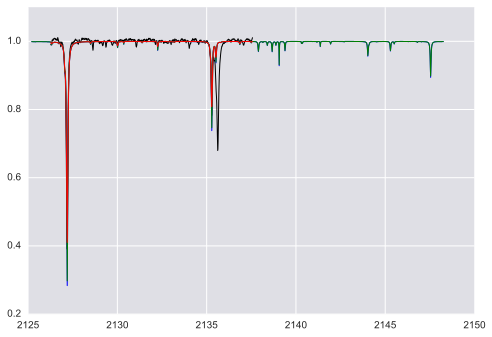

In [48]:
# Plot scalled telluric and convolved value
plt.plot(wl2, I2_not_h20_corr, 'k', label="Obs")
plt.plot(tell_data2[0], tell_data2[1], 'b', label="Original tell")
plt.plot(Scalled_tell2[0], Scalled_tell2[1], 'g', label="Scaled")
plt.plot(Interped_conv_tell2[0], Interped_conv_tell2[1], 'r', label="Scaled +convolved")
plt.plot(Interped_conv_tell2[0], Interped_just_conv_tell2, 'm', label="Just convolved")
#plt.legend()

# Make it interactive with Bokeh
bokeh.plotting.show(bokeh.mpl.to_bokeh())

In [ ]:
# plot corrected value


In [ ]:
%%timeit
# Time the Peform minimization
out = minimize(h20_residual, params, args=([wl2, I2_not_h20_corr], tell_data2))
outreport = lmfit.fit_report(out)
print(outreport)

In [ ]:
1.9*1000/.831


### Apply correction with best scaling power:

And plot the result.

# PARALLELISATION CODES /ATTEMPTS

In [ ]:
from math import sqrt
from joblib import Parallel, delayed

def convolve(wav, R, wav_extended, flux_extended, FWHM_lim):
        # select all values such that they are within the FWHM limits
        FWHM = wav/R
        indexes = [ i for i in range(len(wav_extended)) if ((wav - FWHM_lim*FWHM) < wav_extended[i] < (wav + FWHM_lim*FWHM))]
        flux_2convolve = flux_extended[indexes[0]:indexes[-1]+1]
        IP = unitary_Gauss(wav_extended[indexes[0]:indexes[-1]+1], wav, FWHM)
        val = np.sum(IP*flux_2convolve) 
        unitary_val = np.sum(IP*np.ones_like(flux_2convolve))  # Effect of convolution onUnitary. For changing number of points
        return val/unitary_val
    
def fast_convolve(wav, R, wav_extended, flux_extended, FWHM_lim):
    FWHM = wav/R
    
    index_mask = (wav_extended > (wav - FWHM_lim*FWHM)) &  (wav_extended < (wav + FWHM_lim*FWHM))
    
    flux_2convolve = flux_extended[index_mask]
    IP = unitary_Gauss(wav_extended[index_mask], wav, FWHM)
    
    val = np.sum(IP*flux_2convolve) 
    unitary_val = np.sum(IP*np.ones_like(flux_2convolve))  # Effect of convolution onUnitary. For changing number of points
        
    return val/unitary_val
    
def parallel_convolution(wav, flux, chip, R, FWHM_lim=5.0, n_jobs=-1, parallel_workers=None):
    """Convolution code adapted from pedros code"""
    
    wav_chip, flux_chip = chip_selector(wav, flux, chip)
    #we need to calculate the FWHM at this value in order to set the starting point for the convolution
    
    #print(wav_chip)
    #print(flux_chip)
    FWHM_min = wav_chip[0]/R    #FWHM at the extremes of vector
    FWHM_max = wav_chip[-1]/R       
    
    #wide wavelength bin for the resolution_convolution
    wav_extended, flux_extended = fast_wav_selector(wav, flux, wav_chip[0]-FWHM_lim*FWHM_min, wav_chip[-1]+FWHM_lim*FWHM_max) 
    wav_extended = np.array(wav_extended, dtype="float64")
    flux_extended = np.array(flux_extended, dtype="float64")
    
    print("Starting the Parallel Resolution convolution...")
    
    flux_conv_res = []
    counter = 0    
    # lambda doesnt work in parallel - it doesn't pickel 
    #lambda_funct = lambda x: convolve(x,R,wav_extended, flux_extended,FWHM_lim)
    #parallel_result = Parallel(n_jobs=-1)(delayed(lambda_funct)(wav) for wav in wav_chip)
    
    #for wav in wav_chip:
    #    a = convolve(wav,R,wav_extended, flux_extended,FWHM_lim)
    #    a = lambda_funct(wav)
    #    flux_conv_res.append(a)
    #    if(len(flux_conv_res)%(len(wav_chip)//100 ) == 0):
    #        counter = counter+1
    #        print("Resolution Convolution at {}%%...".format(counter))
    #flux_conv_res = np.array(flux_conv_res, dtype="float64")
    
    
    # select all values such that they are within the FWHM limits
    #   FWHM = wav/R
    #   indexes = [ i for i in range(len(wav_extended)) if ((wav - FWHM_lim*FWHM) < wav_extended[i] < (wav + FWHM_lim*FWHM))]
    #   flux_2convolve = flux_extended[indexes[0]:indexes[-1]+1]
    #   IP = unitary_Gauss(wav_extended[indexes[0]:indexes[-1]+1], wav, FWHM)
    #   flux_conv_res.append(np.sum(IP*flux_2convolve))
    if parallel_workers:
        # If given workes to use
         parallel_result = parallel_workers(delayed(convolve)(wav,R,wav_extended, flux_extended,FWHM_lim) for wav in wav_chip)
    else:
        parallel_result = Parallel(n_jobs=n_jobs)(delayed(convolve)(wav,R,wav_extended, flux_extended,FWHM_lim) for wav in wav_chip)
    flux_conv_res = np.array(parallel_result, dtype="float64")
    print("Done.\n")
    
    
    return wav_chip, flux_conv_res 


-
print("function done")
print("function done")

## Try parrellel processing for the convolution

 from math import sqrt
 from joblib import Parallel, delayed
 Parallel(n_jobs=2)(delayed(sqrt)(i ** 2) for i in range(10))

In [ ]:
import time
import datetime
start = time.time()
print("start time", datetime.datetime.now().time())

%prun parallel_x, parallel_y = parallel_convolution(tapas_h20_data[0], tapas_h20_data[1], "1", 50000, FWHM_lim=5.0, n_jobs=-1)
  
done = time.time()
print("end time", datetime.datetime.now().time())
elapsed = done - start
print("Convolution time = ", elapsed)


### Need to try running this code as a script not in the notebook to see if it works and is faster.
#Will be benificial if trying to find the best scaling factor

#Maybe good idea to find a general rule of thumb for height/depth of lines need to get to 


In [ ]:
# Test passing it hte parallel worker
start = time.time()
with Parallel(n_jobs=-1, verbose=1) as parallel:
    par_x, par_y = parallel_convolution(tapas_h20_data[0], tapas_h20_data[1], "1", 50000, FWHM_lim=5.0, n_jobs=-1, parallel_workers=parallel)
  
done = time.time()
print("Convolution time = ", done - start)

In [ ]:
import time
import datetime
start = time.time()
print("start time", datetime.datetime.now().time())

parallel_fast_x, parallel_fast_y = fast_convolution(tapas_h20_data[0], tapas_h20_data[1], "1", 50000, FWHM_lim=5.0)
  
done = time.time()
print("end time", datetime.datetime.now().time())
elapsed = done - start
print("Convolution time for rast convolution = ", elapsed)

In [ ]:
# Saving a result for comparison

#np.savetxt("Convolved_50000_tapas_wavelength_allchips.txt", parallel_x)
#np.savetxt("Convolved_50000_tapas_transmitance_allchips.txt", parallel_y)

#np.savetxt("Convolved_50000_tapas_wavelength_allchips_dividebynumber.txt", parallel_x)
#np.savetxt("Convolved_50000_tapas_transmitance_allchips_dividebynumber.txt", parallel_y)

# Testing Parallel processing convolution times.

### Windows laptop
Convolution time =  868.3053071498871   # parallel code 1 process

Convolution time =  981.6766209602356   # parallel 2 jobs, backend="threading"

Convolution time =  899.5289189815521   # parallel -1 jobs, backend="threading"

Convolution time =  2408.0208117961884  # parallel n_jobs=4, backend="threading"   ~40min

Convolution time =  983.7938089370728   # n_jobs=1, backend="threading"   ~16min


### Linux Work comp
Convolution time =  54.9865338802               # n_jobs=-1

Convolution time =  184.560889959               # n_jobs=1      ~ 3 min

Convolution time =  99.8279280663               # n_jobs=2      ~ 1.5 min 

Convolution time =  68.0848469734               # n_jobs=3      ~ 1 min

Convolution time =  56.3469331264               # n_jobs=4      < 1 min

Convolution time =  253.075296164             # Work comp  # n_jobs=-1, backend="threading"


### All chips at once - condition "0"
linux on parallel  
Convolution time =  1150.128829s



My conclusion is that joblib does a great job and increase the convolution speed for this task on linux. Threading is not good for this instance.

In [ ]:
plt.plot(tapas_h20_data[0], tapas_h20_data[1], "b")
#plt.plot(x,y/np.max(y), "r")
plt.plot(parallel_x, parallel_y, "-r")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Flux")
plt.title("Test of convolutions")
#plt.show()
# Make it interactive with Bokeh
bokeh.plotting.show(bokeh.mpl.to_bokeh())

### Fit best scaling power.
Does each chip need a differnet scaling power?


In [ ]:
from lmfit import minimize, Parameters
import lmfit

In [ ]:
from scipy.interpolate import interp1d
def match_wl(wl, spec, ref_wl, method="scipy", kind="linear"):
    """Interpolate Wavelengths of spectra to common WL
    Most likely convert telluric to observed spectra wl after wl mapping performed"""
    starttime = time.time()
    if method == "scipy":
        print(kind + " scipy interpolation")
        linear_interp = interp1d(wl, spec, kind=kind)
        new_spec = linear_interp(ref_wl)
    elif method == "numpy":
        if kind.lower() is not "linear":
            print("Warning: Cannot do " + kind + " interpolation with numpy, switching to linear" )
        print("Linear numpy interpolation")
        new_spec = np.interp(ref_wl, wl, spec)  # 1-d peicewise linear interpolat
    else:
        print("Method was given as " + method)
        raise("Not correct interpolation method specified")
    print("Interpolation Time = " + str(time.time() - starttime) + " seconds")

    return new_spec  # test inperpolations 

def slice_spectra(wl, spectrum, low, high):
    """ Extract a section of a spectrum between wavelength bounds. 
        """
    #print("lower bound", low)
    #print("upper bound", high)
    map1 = wl > low
    map2 = wl < high
    wl_sec = wl[map1*map2]
    spectrum_sec = spectrum[map1*map2]   
    return wl_sec, spectrum_sec 



In [ ]:
### Fit using lmfit
# parallel version of h20 residuals before np speed up.
# bad as it has the Parallel creation inside the fit function / was fixed at work but don't know how these will merge
def h20_residual(params, obs_data, telluric_data):
    # Parameters 
    ScaleFactor = params["ScaleFactor"].value
    R = params["R"].value
    FWHM_lim = params["FWHM_lim"].value
    n_jobs = params["n_jobs"].value  # parallel implementaiton
    chip_select = params["chip_select"].value
    parallel_workers = params["parallel_workers"].value  # Joblib parallel worker
    
    # Data
    obs_wl = obs_data[0]
    obs_I = obs_data[1]
    telluric_wl = telluric_data[0]
    telluric_I = telluric_data[1]
    
    # Telluric scaling T ** x
    scaled_telluric_I = telluric_I ** ScaleFactor
    
    # Convolution
    convolved_telluric = parallel_convolution(telluric_wl, scaled_telluric_I, str(chip_select), R, FWHM_lim=FWHM_lim, n_jobs=n_jobs, parallel_workers=parallel_workers)
    interped_telluric = match_wl(telluric_wl, telluric_I, obs_wl)
    print("Convolution inside residual function was done")
    
    return 1 - (obs_I / convolved_telluric) 


In [18]:
# Set up parameters 
params = Parameters()
params.add('ScaleFactor', value=1)
params.add('R', value=50000, vary=False)
params.add('FWHM_lim', value=5, vary=False)
params.add('n_jobs', value=-1, vary=False)
params.add('chip_select', value=2, vary=False)


In [17]:
#wl2, I2_uncorr
# wl2, I2_not_h20_corr

# Sliced to wavelength measurement of detector
tell_data1 = fast_wav_selector(tapas_h20_data[0], tapas_h20_data[1], 0.95*min(wl1), 1.05*max(wl1))
tell_data2 = fast_wav_selector(tapas_h20_data[0], tapas_h20_data[1], 0.95*min(wl2), 1.05*max(wl2))
tell_data3 = fast_wav_selector(tapas_h20_data[0], tapas_h20_data[1], 0.95*min(wl3), 1.05*max(wl3))
tell_data4 = fast_wav_selector(tapas_h20_data[0], tapas_h20_data[1], 0.95*min(wl4), 1.05*max(wl4))

               
print("Number of values to iterate", len(tell_data2[0]))

Number of values to iterate 114081


In [ ]:
# test outside of fit
print("Starting test")
with Parallel(n_jobs=-1, verbose=1) as parallel:
    params.add('parallel_workers', value=parallel, vary=False)
    residual = h20_residual(params,[wl2, I2_not_h20_corr], tell_data2)

In [ ]:
# Peform minimization
with Parallel(n_jobs=-1) as parallel:
    params.add('parallel_workers', value=parallel, vary=False)
    out = minimize(h20_residual, params, args=([wl2, I2_not_h20_corr], tell_data2))
outreport = lmfit.fit_report(out)
print(outreport)


# Timing test of code

In [ ]:
## Time difference between my slice spectra and pedros wave selector
%timeit wav_selector(tapas_h20_data[0], tapas_h20_data[1], min(wl1), max(wl4))


In [ ]:
%timeit slice_spectra(tapas_h20_data[0], tapas_h20_data[1], min(wl1), max(wl4))

Therefore Pedros wav_selector is faster/more efficent than my code. Should adjust my code accordingly.
I should probably move this to a different notebook.

### Apply correction with best scaling power:

And plot the result.